In [84]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import json
import cPickle as pk
import os
import sys
import numpy as np
import pandas as pd
from time import time
import cv2
import matplotlib.pyplot as plt
import re
from glob import iglob
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# need to change up a dir on the server for some reason...
os.chdir('..')

In [4]:
pwd

u'/home/ubuntu/canna-recommend'

In [138]:
def create_model(output_layer='block4_pool'):
    base_model = VGG19(weights='imagenet')
    model = Model(input=base_model.input, output=base_model.get_layer(output_layer).output)
    return model

def extract_feats(model, img_path, heavy_crop=None):
        try:
            # need to crop out logo from image
            # probably better to do more scaling to get center of image
            if heavy_crop == True:
                img = image.load_img(ims[0], target_size=(350, 350))
                img = img.crop((0, 0, 224, 224))
            else:
                # this will do minimum scaling
                img = image.load_img(ims[0], target_size=(300, 300))
                img = img.crop((50, 50, 224 + 50, 224 + 50))
            
        except IOError:
            print 'couldn\'t load file'
            return None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = model.predict(x)
        return features

In [6]:
ims = list(iglob('analytical360/images/*.jpg'))

In [7]:
ims[0]

'analytical360/images/egbsourdiesel1570533070.jpg'

In [8]:
len(ims)

3963

In [9]:
model = create_model(output_layer='block4_pool')

In [10]:
feats = extract_feats(model, ims[0])

In [11]:
feats[0, :, :, 0].shape # weird indexing is different than normal too... usually just feats[0][0] does it

(14, 14)

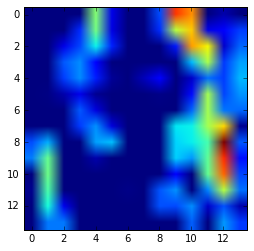

In [12]:
f = plt.imshow(feats[0, :, :, 0])

In [13]:
img = image.load_img(ims[0], target_size=(224, 224))
print img

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2FA9483E10>


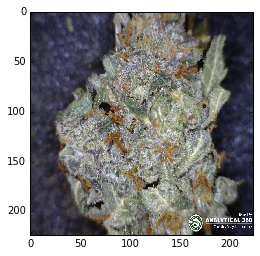

In [14]:
f = plt.imshow(img)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2FA9557390>


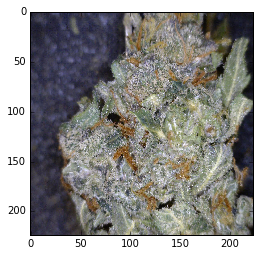

In [15]:
img = image.load_img(ims[0], target_size=(250, 250))
img = img.crop((0, 0, 224, 224))
print img
f = plt.imshow(img)

# Now for the production/training

In [16]:
model = create_model(output_layer='fc2')

In [17]:
all_df = pd.read_pickle('analytical360/data_df_11-13-2016.pk')

In [18]:
all_df.iloc[0]

cbc                                    NaN
cbd_total                             0.09
cbg                                   0.25
cbn                                    0.1
name                            Royal Kush
thc_total                            21.59
Caryophyllene                          NaN
Humulene                               NaN
Limonene                               NaN
Linalool                               NaN
Myrcene                                NaN
Terpinolene                            NaN
alpha_pinene                           NaN
caryophyllene_oxide                    NaN
total_terpenes                         NaN
isedible                                 0
filename               royalkush494114.jpg
clean_name                       royalkush
Name: 1, dtype: object

In [62]:
all_df['total_canna'] = all_df['cbd_total'] + \
                        all_df['thc_total'] + \
                        all_df['cbc'].fillna(all_df['cbc'].mean()) + \
                        all_df['cbg'].fillna(all_df['cbg'].mean())

In [63]:
target = all_df['total_canna'].values
ims = ['analytical360/images/' + f for f in all_df['filename'].values]

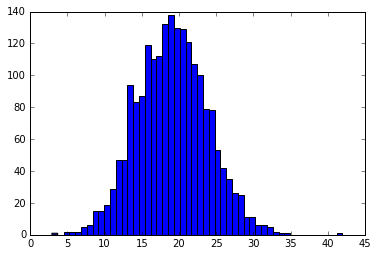

In [85]:
f = plt.hist(target, bins=50)

In [98]:
low_df = all_df[all_df['total_canna'] < 10]

In [99]:
low_df.shape

(48, 19)

In [100]:
low_df.iloc[0]

cbc                               NaN
cbd_total                        3.13
cbg                               NaN
cbn                               NaN
name                            AC/DC
thc_total                        1.89
Caryophyllene                    0.47
Humulene                         0.53
Limonene                          NaN
Linalool                          NaN
Myrcene                           NaN
Terpinolene                       NaN
alpha_pinene                      NaN
caryophyllene_oxide               NaN
total_terpenes                      1
isedible                            0
filename               acdc442857.jpg
clean_name                       acdc
total_canna                    5.3149
Name: 209, dtype: object

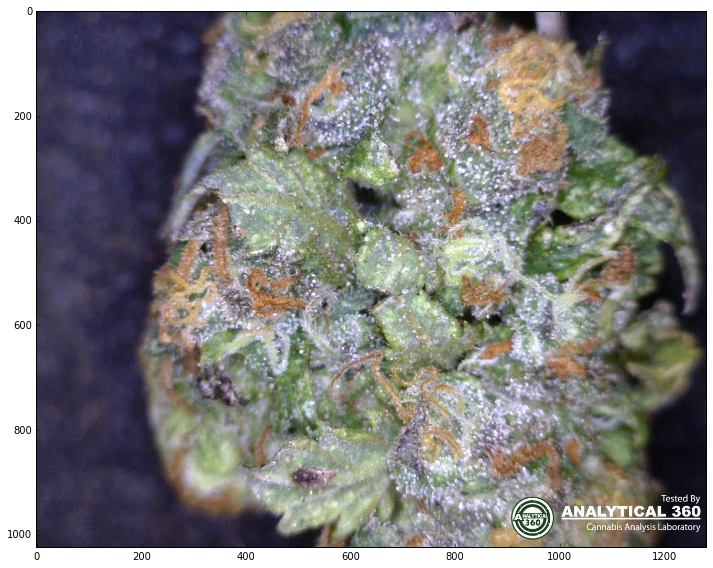

In [107]:
img = image.load_img('analytical360/images/' + low_df.iloc[0]['filename'])
f = plt.figure(figsize=(12, 12))
f = plt.imshow(img)

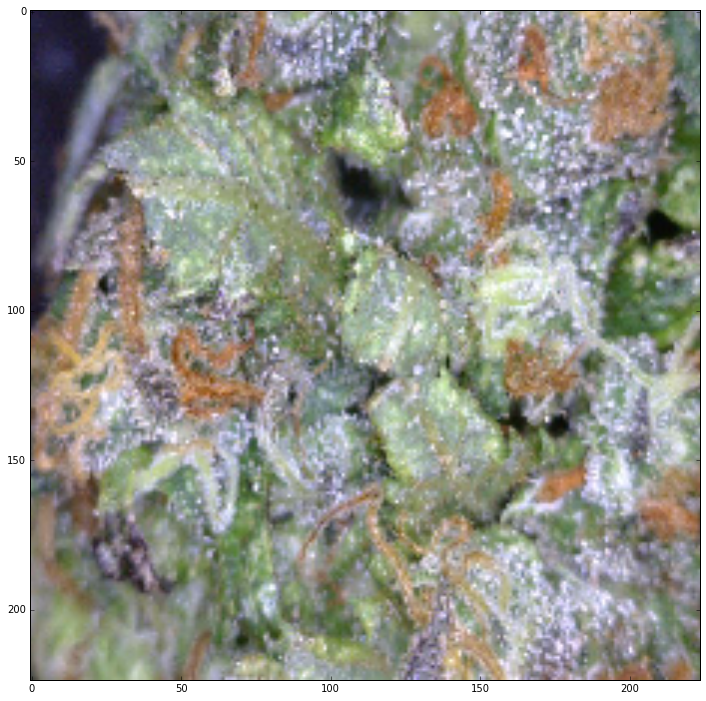

In [135]:
# hmm maybe try to crop the image a bit to get rid of blueness
img = image.load_img('analytical360/images/' + low_df.iloc[0]['filename'], target_size=(350, 350))
img = img.crop((63, 63, 224 + 63, 224 + 63))
f = plt.figure(figsize=(12, 12))
f = plt.imshow(img)

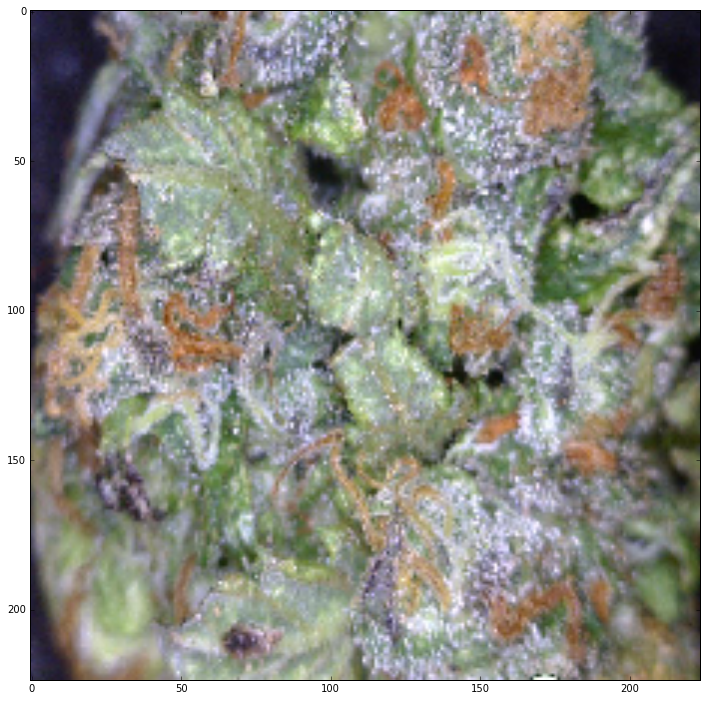

In [137]:
img = image.load_img('analytical360/images/' + low_df.iloc[0]['filename'], target_size=(300, 300))
img = img.crop((50, 50, 224 + 50, 224 + 50))
f = plt.figure(figsize=(12, 12))
f = plt.imshow(img)

In [108]:
hi_df = all_df[all_df['total_canna'] > 28]

In [109]:
hi_df.iloc[0]

cbc                                   NaN
cbd_total                            0.28
cbg                                   NaN
cbn                                   NaN
name                            Jedi Kush
thc_total                           30.95
Caryophyllene                        0.42
Humulene                             0.83
Limonene                              NaN
Linalool                              NaN
Myrcene                              0.05
Terpinolene                           NaN
alpha_pinene                         0.07
caryophyllene_oxide                   NaN
total_terpenes                       1.37
isedible                                0
filename               jedikush377637.jpg
clean_name                       jedikush
total_canna                       31.5249
Name: 6, dtype: object

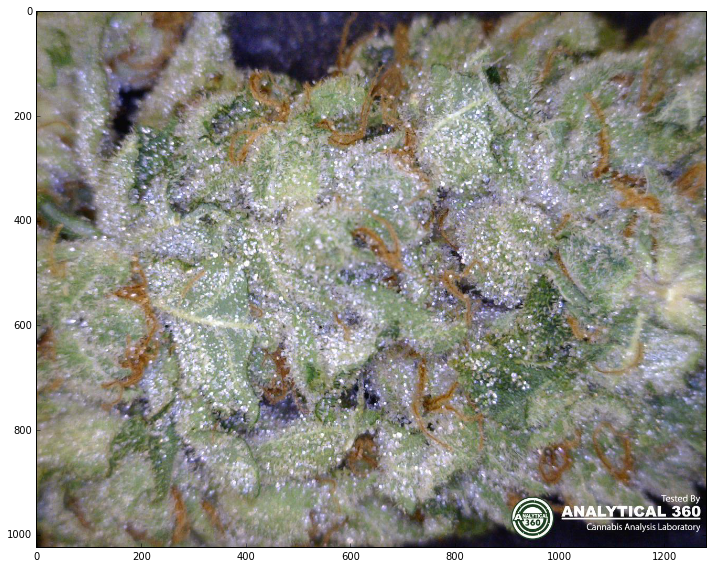

In [110]:
img = image.load_img('analytical360/images/' + hi_df.iloc[0]['filename'])
f = plt.figure(figsize=(12, 12))
f = plt.imshow(img)

In [65]:
target[0]

21.974383333333332

In [66]:
len(target)

2034

In [28]:
feats = []
for i in ims:
    start = time()
    feats.append(model, extract_feats(i))
    print 'took', time() - start, 'seconds'

took 1.25276994705 seconds
took 0.0795071125031 seconds
took 0.0792119503021 seconds
took 0.0790929794312 seconds
took 0.0658349990845 seconds
took 0.0657210350037 seconds
took 0.0655810832977 seconds
took 0.0667159557343 seconds
took 0.0655391216278 seconds
took 0.0658860206604 seconds
took 0.0640180110931 seconds
took 0.0645208358765 seconds
took 0.0634729862213 seconds
took 0.0632650852203 seconds
took 0.0632519721985 seconds
took 0.0767230987549 seconds
took 0.07666015625 seconds
took 0.0763189792633 seconds
took 0.0633978843689 seconds
took 0.0763640403748 seconds
took 0.0758290290833 seconds
took 0.0758631229401 seconds
took 0.076385974884 seconds
took 0.0761539936066 seconds
took 0.0764300823212 seconds
took 0.0767669677734 seconds
took 0.0766630172729 seconds
took 0.0765891075134 seconds
took 0.0770988464355 seconds
took 0.0765039920807 seconds
took 0.0768718719482 seconds
took 0.0770218372345 seconds
took 0.0763700008392 seconds
took 0.0764331817627 seconds
took 0.076952934265

In [32]:
feats = np.array(feats)
feats = feats[:, 0, :] # again with the weird indexing

In [111]:
pk.dump(feats, open('analytical360/nn_feats_fc2.pk', 'w'), 2)
pk.dump(ims, open('analytical360/nn_ims.pk', 'w'), 2)
pk.dump(target, open('analytical360/nn_target.pk', 'w'), 2)

In [67]:
train_x, test_x, train_y, test_y = train_test_split(feats, target, random_state=42)

In [68]:
train_x.shape

(1525, 4096)

In [69]:
test_x.shape

(509, 4096)

In [70]:
from sklearn.svm import SVR
clf = SVR()
clf.fit(train_x, train_y)
clf.score(test_x, test_y)

-0.010064580407904256

In [78]:
clf.predict(test_x[0].reshape(1, -1))[0] # annoying reshape bs...

18.8977084625323

In [79]:
test_y[0]

17.800000000000001

In [80]:
print clf.predict(test_x[10].reshape(1, -1))[0]
print test_y[10]

18.8977084625
14.9649001292


In [81]:
from sklearn.ensemble import GradientBoostingRegressor

In [86]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y)

-0.0070155246211993649

In [87]:
gbr = GradientBoostingRegressor(loss='huber', learning_rate=0.01, n_estimators=500, subsample=0.4, random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y)

-0.008253902164187199

In [89]:
gbr = GradientBoostingRegressor(subsample=0.4, random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y)

-0.0065450081709010899

In [93]:
gbr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, subsample=0.4, random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y) 

-0.0062449625800820021

In [94]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=1000,
                                subsample=0.4,
                                max_depth=6,
                                random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y) 

-0.0062449625800820021

In [95]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=1000,
                                subsample=0.35,
                                max_depth=6,
                                random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y) 

-0.0062015409655924456

In [97]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=1000,
                                subsample=0.4,
                                max_depth=6,
                                max_features='sqrt',
                                random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y) 

-0.0062449625800820021

# hmm, maybe too deep in the net...

In [112]:
model = create_model(output_layer='flatten')

In [115]:
testf = extract_feats(i)

In [116]:
testf.shape

(1, 25088)

In [117]:
model = create_model(output_layer='fc1')

In [118]:
testf = extract_feats(i)

In [119]:
testf.shape

(1, 4096)

In [120]:
feats_fc1 = []
for i in ims:
    start = time()
    feats_fc1.append(extract_feats(model, i))
    print 'took', time() - start, 'seconds'

took 0.0795578956604 seconds
took 0.0788700580597 seconds
took 0.0788288116455 seconds
took 0.0746829509735 seconds
took 0.0715811252594 seconds
took 0.0710909366608 seconds
took 0.0659558773041 seconds
took 0.0654268264771 seconds
took 0.0655090808868 seconds
took 0.0650861263275 seconds
took 0.066262960434 seconds
took 0.0644629001617 seconds
took 0.0629420280457 seconds
took 0.0627009868622 seconds
took 0.0635411739349 seconds
took 0.062912940979 seconds
took 0.0625860691071 seconds
took 0.0628340244293 seconds
took 0.0650150775909 seconds
took 0.0614809989929 seconds
took 0.0612809658051 seconds
took 0.0610809326172 seconds
took 0.0616588592529 seconds
took 0.0612049102783 seconds
took 0.0611250400543 seconds
took 0.0615508556366 seconds
took 0.0749659538269 seconds
took 0.0745170116425 seconds
took 0.0748188495636 seconds
took 0.0614819526672 seconds
took 0.0618109703064 seconds
took 0.0614740848541 seconds
took 0.0615270137787 seconds
took 0.0619790554047 seconds
took 0.061232089

In [125]:
feats_fc1 = np.array(feats_fc1)
feats_fc1 = feats_fc1[:, 0, :]

In [128]:
pk.dump(feats_fc1, open('analytical360/nn_feats_fc1.pk', 'w'), 2)

In [129]:
feats_fc1.shape

(2034, 4096)

In [130]:
train_x, test_x, train_y, test_y = train_test_split(feats_fc1, target, random_state=42)

In [131]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=1000,
                                subsample=0.35,
                                max_depth=6,
                                random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y) 

-0.0062015409655924456

# try it with cropping the image more...

In [139]:
feats_fc1_hc = []
for i in ims:
    start = time()
    feats_fc1_hc.append(extract_feats(model, i, heavy_crop=True))
    print 'took', time() - start, 'seconds'

took 0.0793759822845 seconds
took 0.0773198604584 seconds
took 0.0773499011993 seconds
took 0.0888631343842 seconds
took 0.0739898681641 seconds
took 0.070839881897 seconds
took 0.0702910423279 seconds
took 0.0692269802094 seconds
took 0.0664429664612 seconds
took 0.0665400028229 seconds
took 0.0800840854645 seconds
took 0.0666551589966 seconds
took 0.0657460689545 seconds
took 0.0656750202179 seconds
took 0.0659830570221 seconds
took 0.0636959075928 seconds
took 0.0641069412231 seconds
took 0.0634138584137 seconds
took 0.0619759559631 seconds
took 0.062175989151 seconds
took 0.0629270076752 seconds
took 0.0622401237488 seconds
took 0.0756359100342 seconds
took 0.0742030143738 seconds
took 0.074245929718 seconds
took 0.0740559101105 seconds
took 0.0738060474396 seconds
took 0.0742030143738 seconds
took 0.0740010738373 seconds
took 0.0739140510559 seconds
took 0.0740230083466 seconds
took 0.0610959529877 seconds
took 0.0608329772949 seconds
took 0.0617368221283 seconds
took 0.0611081123

In [141]:
feats_fc1_hc = np.array(feats_fc1_hc)
feats_fc1_hc = feats_fc1_hc[:, 0, :]

In [142]:
pk.dump(feats_fc1_hc, open('analytical360/nn_feats_fc1_crop.pk', 'w'), 2)

In [143]:
train_x, test_x, train_y, test_y = train_test_split(feats_fc1, target, random_state=42)

In [144]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=1000,
                                subsample=0.35,
                                max_depth=6,
                                random_state=42)
gbr.fit(train_x, train_y)
gbr.score(test_x, test_y) 

-0.0062015409655924456